In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation as LDA
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns


c:\Users\saura\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

# Download the punkt_tab data
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
# Step 1: Load The Datasets
train_file_path = "C:/Users/saura/Downloads/training.1600000.processed.noemoticon.csv"
test_file_path = "C:/Users/saura/Downloads/testdata.manual.2009.06.14.csv"

In [6]:
# Load the datasets
train_data = pd.read_csv(train_file_path, encoding="latin-1", header=None)
test_data = pd.read_csv(test_file_path,encoding="latin-1", header=None)

In [7]:
train_data = train_data[[0,5]].rename(columns={0: "sentiment", 5: "tweet"})
test_data = test_data[[0,5]].rename(columns={0: "sentiment", 5: "tweet"})

In [8]:
# Step 2: Clean the text
def clean_tweet(text):
  text = re.sub(f"@\w+", "", text)
  text = re.sub(r"#\w+", "", text)
  text = re.sub(r"http\S+|www.\S+", "", text)
  text = re.sub(r"[^\w\s]", "", text)
  return text.lower().strip()

In [9]:
train_data["cleaned_tweet"] = train_data["tweet"].apply(clean_tweet)
test_data["cleaned_tweet"] = test_data["tweet"].apply(clean_tweet)


In [10]:
# Step 3: Preprocess text (Tokenize, Lemmatize)
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


In [12]:
def preprocess_text(text):
  tokens = word_tokenize(text)
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
  return " ".join(tokens)

In [13]:
train_data["processed_tweet"] = train_data["cleaned_tweet"].apply(preprocess_text)
test_data["processed_tweet"] = test_data["cleaned_tweet"].apply(preprocess_text)


In [14]:
train_data["sentiment"] = train_data["sentiment"].map({0: "Negative", 4: "Positive"})
test_data["sentiment"] = test_data["sentiment"].map({0: "Negative", 4: "Positive"})

In [15]:
# Step 4: Train-Test Split (from Training data)
X_train, X_val, y_train, y_val = train_test_split(
    train_data["processed_tweet"],
    train_data["sentiment"].map({"Negative": 0, "Positive": 1}),
    test_size=0.2,
    random_state=42,
)

In [16]:
y_train = y_train.dropna()
X_train = X_train[y_train.index]

In [17]:
most_frequent_class = y_train.mode()[0]
y_train = y_train.fillna(most_frequent_class)

In [18]:
print(y_train.value_counts())

sentiment
0    640506
1    639494
Name: count, dtype: int64


In [19]:
# Step 5: Vectorize the text
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(test_data["processed_tweet"])

In [20]:
# Step 6: Train a sentiment classifier
classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

LogisticRegression()

In [22]:
X_val_tfidf = vectorizer.transform(X_val)

In [23]:
# Step 7: Evaluate the classifier
# On Validation Set
y_val_pred = classifier.predict(X_val_tfidf)
print("Validation Set Classification Report:\n", classification_report(y_val, y_val_pred))


Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77    159494
           1       0.76      0.79      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [24]:
import joblib

# Save the trained model and vectorizer to disk
joblib.dump(classifier, "sentiment_classifier.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [25]:
# Drop rows with NaN in the sentiment column
test_data = test_data.dropna(subset=["sentiment"])

# Recompute the vectorized features for the filtered test data
X_test_tfidf = vectorizer.transform(test_data["processed_tweet"])

# Ensure the lengths of predictions and labels match
y_test_pred = classifier.predict(X_test_tfidf)

# Evaluate the model
print("Test Set Classification Report:\n", classification_report(test_data["sentiment"], y_test_pred))


TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['Negative' 'Positive'] and y_pred=[0 1]. Make sure that the predictions provided by the classifier coincides with the true labels.

In [88]:
print(f"Number of samples in test_data: {len(test_data)}")
print(f"Number of samples in X_test_tfidf: {X_test_tfidf.shape[0]}")

Number of samples in test_data: 359
Number of samples in X_test_tfidf: 359


In [90]:
# Step 8: Word Clouds for Training and Test Data
# Positive and Negative text for both datasets
positive_train_text = " ".join(train_data[train_data["sentiment"] == "Positive"]["processed_tweet"])
negative_train_text = " ".join(train_data[train_data["sentiment"] == "Negative"]["processed_tweet"])

positive_test_text = " ".join(test_data[test_data["sentiment"] == "Positive"]["processed_tweet"])
negative_test_text = " ".join(test_data[test_data["sentiment"] == "Negative"]["processed_tweet"])

In [91]:
# Plot word clouds

def plot_wordcloud(text, title, bg_color="white"):
  wordcloud = WordCloud(width=800, height=400, background_color=bg_color).generate(text)
  plt.figure(figsize=(10,6))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.title(title, fontsize=18)
  plt.axis("off")
  plt.show()

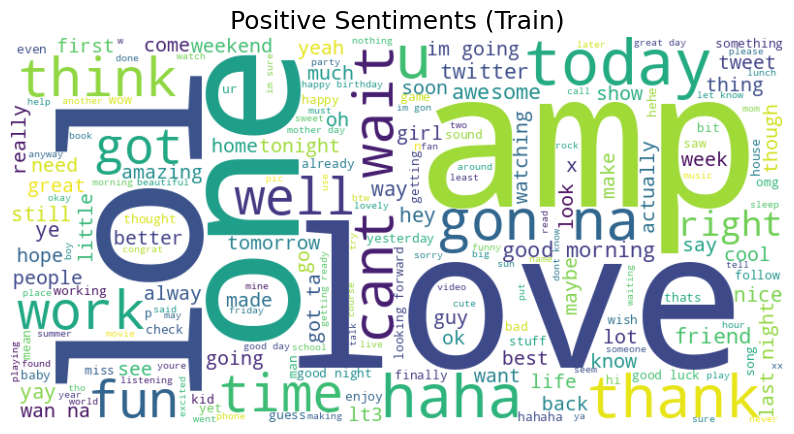

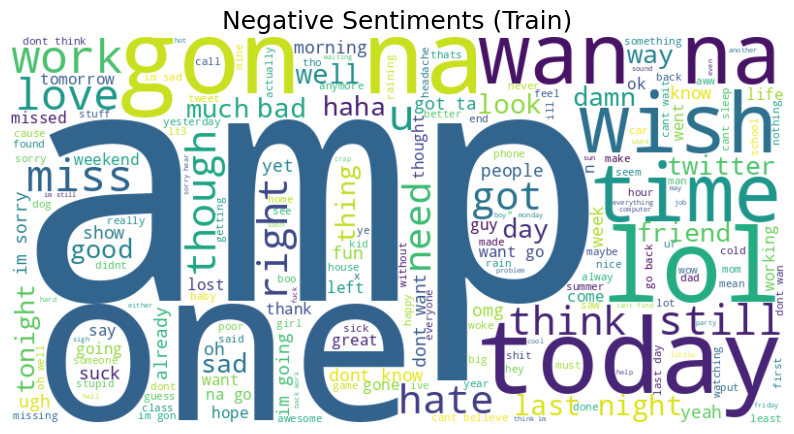

In [93]:
# Safely generate word clouds

if positive_train_text:
  plot_wordcloud(positive_train_text, "Positive Sentiments (Train)")

if negative_train_text:
  plot_wordcloud(negative_train_text, "Negative Sentiments (Train)")

if positive_test_text:
  plot_wordcloud(positive_test_text, "Positive Sentiments (Test)")

if negative_test_text:
  plot_wordcloud(negative_test_text, "Negative Sentiments (Test)")

In [94]:
# Step 9: Save the processed data
train_data.to_csv("processed_train_data.csv", index=False)
test_data.to_csv("processes_test_data.csv", index=False)